In [1]:

library(tidyverse) # metapackage of all tidyverse packages
library(ggplot2)
library(dplyr)
# install.packages("zipcodeR")
# library(zipcodeR)
# list.files(path = "../input")
library(MASS)
library(caTools)
library(Metrics)
library(xgboost)
# library(randomForest)
# install.packages("BART")
# library(BART)
# install.packages("neuralnet")
# library(neuralnet)
library(caret)
library(glmnet)
# install.packages('bartMachine')
# library(bartMachine)
# install.packages("rpart")
library(rpart)
library(rpart.plot)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.5 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select



Attaching package: ‘xgboost’


The following object is masked from ‘package:dplyr’:

    slice


Loading required package: lattice


Attaching package: ‘caret’


The following objects are masked from ‘package:Metrics’:

    precision, recall


The following object is masked from ‘package:purrr’:

    lift


The following object is masked from ‘package:httr’:

    progress


Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pa

In [2]:
train <- read.csv('/kaggle/input/train-test-stat/stat_5600_train_df.csv')
test <- read.csv('/kaggle/input/train-test-stat/stat_5600_test_df.csv')

In [3]:
head(train)

,b2c_c2c,seller_id,declared_handling_days,shipment_method_id,shipping_fee,item_zip,buyer_zip,category_id,item_price,quantity,delivery_date,weight,package_size,carrier_average_estimate,zip_distance,acceptance_date,payment_date,time_to_process,days_to_deliver,acceptance_to_delivery
,<int>,<dbl>,<int>,<int>,<dbl>,<int>,<int>,<int>,<dbl>,<int>,<chr>,<dbl>,<int>,<dbl>,<dbl>,<chr>,<chr>,<int>,<int>,<int>
1,0,4677,1,0,0.00,90703,55070,1,25.00,1,2018-07-30,1.360776,6,4,1528.26,2018-07-27,2018-07-26,1,4,3
2,0,104,1,0,0.00,91304,60565,11,5.70,1,2019-02-11,0.000000,6,4,1734.01,2019-02-08,2019-02-08,0,3,3
3,0,340356,1,0,2.95,49735,29379,1,6.00,1,2018-04-25,0.453592,6,4,728.16,2018-04-23,2018-04-22,1,3,2
4,0,2101,1,0,0.00,51031,28092,13,9.90,1,2018-05-14,0.907184,6,4,943.44,2018-05-08,2018-05-07,1,7,6
5,0,12924,1,0,0.00,77035,45373,8,23.99,1,2018-08-09,0.453592,6,4,957.60,2018-08-06,2018-08-06,0,3,3
6,0,5815,0,0,0.00,32605,33166,11,22.78,2,2019-05-22,3.628736,6,4,294.74,2019-05-21,2019-05-20,1,2,1


In [4]:
dev.new(width=5, height=4, unit="in")
plot(1:20)
dev.new(width = 550, height = 330, unit = "px")
plot(1:15)

In [5]:
str(train)

'data.frame':	5704023 obs. of  20 variables:
 $ b2c_c2c                 : int  0 0 0 0 0 0 0 0 0 0 ...
 $ seller_id               : num  4677 104 340356 2101 12924 ...
 $ declared_handling_days  : int  1 1 1 1 1 0 1 1 1 0 ...
 $ shipment_method_id      : int  0 0 0 0 0 0 0 1 5 0 ...
 $ shipping_fee            : num  0 0 2.95 0 0 0 4 0 0 0 ...
 $ item_zip                : int  90703 91304 49735 51031 77035 32605 20743 77471 83642 92532 ...
 $ buyer_zip               : int  55070 60565 29379 28092 45373 33166 95122 55420 77488 12508 ...
 $ category_id             : int  1 11 1 13 8 11 0 5 1 8 ...
 $ item_price              : num  25 5.7 6 9.9 24 ...
 $ quantity                : int  1 1 1 1 1 2 1 1 1 1 ...
 $ delivery_date           : chr  "2018-07-30" "2019-02-11" "2018-04-25" "2018-05-14" ...
 $ weight                  : num  1.361 0 0.454 0.907 0.454 ...
 $ package_size            : int  6 6 6 6 6 6 6 5 6 6 ...
 $ carrier_average_estimate: num  4 4 4 4 4 4 4 3.5 3.5 4 ...
 $ zip_dista

In [6]:

#loss function
evaluate_loss <- function(preds, actual) {
    early_loss = 0
    late_loss = 0
    for (i in seq(1, length(preds))){
        if (preds[i] < actual[i]){
            #early shipment
            early_loss = early_loss + (actual[i] - preds[i])
        }
        else if (preds[i] > actual[i]){
        #late shipment
            late_loss = late_loss + (preds[i] - actual[i])}
    loss = (1/length(preds)) * ((0.4 * early_loss) + (0.6 * late_loss))
    }
    return(loss)
}

# Multiple Linear Regression

In [7]:
linear_model = lm (days_to_deliver ~ b2c_c2c+ declared_handling_days + shipment_method_id+shipping_fee+item_zip
                   +buyer_zip+category_id+item_price+quantity+ weight+package_size+carrier_average_estimate+zip_distance+time_to_process, data=train)

In [8]:
summary(linear_model)


Call:
lm(formula = days_to_deliver ~ b2c_c2c + declared_handling_days + 
    shipment_method_id + shipping_fee + item_zip + buyer_zip + 
    category_id + item_price + quantity + weight + package_size + 
    carrier_average_estimate + zip_distance + time_to_process, 
    data = train)

Residuals:
    Min      1Q  Median      3Q     Max 
-92.316  -0.859  -0.273   0.465  76.050 

Coefficients:
                           Estimate Std. Error  t value Pr(>|t|)    
(Intercept)               2.216e-01  7.936e-03   27.929  < 2e-16 ***
b2c_c2c                  -7.593e-03  1.585e-03   -4.792 1.66e-06 ***
declared_handling_days    5.180e-02  4.957e-04  104.497  < 2e-16 ***
shipment_method_id        2.122e-02  4.220e-04   50.270  < 2e-16 ***
shipping_fee             -4.749e-03  1.388e-04  -34.220  < 2e-16 ***
item_zip                  4.180e-07  2.393e-08   17.467  < 2e-16 ***
buyer_zip                -8.680e-07  2.462e-08  -35.255  < 2e-16 ***
category_id               1.346e-02  1.050e-04  128.

In [9]:
linear_model_preds =predict(linear_model, test)

In [10]:
rmse_linear_model = rmse(test$days_to_deliver,linear_model_preds )
print(rmse_linear_model)

[1] 1.619933


In [11]:
evaluate_loss(round(linear_model_preds,0), test$days_to_deliver)


2 
0.4896475

# XG boost model

In [12]:

#define predictor and response variables in training set
train_x = data.matrix(train[, c(-11,-16,-17,-19,-20)])
train_y = train[,19]

#define predictor and response variables in testing set
test_x = data.matrix(test[, c(-11,-16,-17,-19,-20)])
test_y = test[, 19]

#define final training and testing sets
xgb_train = xgb.DMatrix(data = train_x, label = train_y)
xgb_test = xgb.DMatrix(data = test_x, label = test_y)

In [13]:
#define watchlist
watchlist = list(train=xgb_train, test=xgb_test)

#fit XGBoost model and display training and testing data at each round
Xgb_model = xgb.train(data = xgb_train, max.depth = 4, watchlist=watchlist, nrounds = 20, eta=0.1)

[1]	train-rmse:4.713490	test-rmse:4.713030 
[2]	train-rmse:4.304879	test-rmse:4.304422 
[3]	train-rmse:3.942361	test-rmse:3.941937 
[4]	train-rmse:3.621455	test-rmse:3.620966 
[5]	train-rmse:3.338526	test-rmse:3.338420 
[6]	train-rmse:3.090012	test-rmse:3.090187 
[7]	train-rmse:2.872045	test-rmse:2.872339 
[8]	train-rmse:2.680177	test-rmse:2.680805 
[9]	train-rmse:2.514930	test-rmse:2.515797 
[10]	train-rmse:2.372085	test-rmse:2.373371 
[11]	train-rmse:2.247403	test-rmse:2.249023 
[12]	train-rmse:2.140560	test-rmse:2.142447 
[13]	train-rmse:2.049502	test-rmse:2.051759 
[14]	train-rmse:1.972329	test-rmse:1.974896 
[15]	train-rmse:1.906533	test-rmse:1.909567 
[16]	train-rmse:1.851778	test-rmse:1.855119 
[17]	train-rmse:1.805056	test-rmse:1.808729 
[18]	train-rmse:1.765789	test-rmse:1.769625 
[19]	train-rmse:1.732547	test-rmse:1.736687 
[20]	train-rmse:1.704226	test-rmse:1.708567 


In [14]:
xgb_model_preds <- predict(Xgb_model, test_x)

In [15]:
evaluate_loss(round(xgb_model_preds,0), test$days_to_deliver)

[1] 0.4370963

In [16]:
importance_matrix = xgb.importance(colnames(xgb_train), model = Xgb_model)
importance_matrix

Feature,Gain,Cover,Frequency
<chr>,<dbl>,<dbl>,<dbl>
time_to_process,9.548387e-01,7.072311e-01,0.616666667
carrier_average_estimate,2.340397e-02,1.328038e-01,0.110000000
zip_distance,1.424457e-02,1.238736e-01,0.133333333
seller_id,4.792382e-03,1.745907e-02,0.080000000
shipment_method_id,1.675396e-03,1.795486e-02,0.010000000
declared_handling_days,7.399077e-04,4.612030e-04,0.036666667
item_zip,1.566837e-04,6.683879e-07,0.003333333
package_size,7.848858e-05,2.131741e-04,0.006666667
item_price,6.995132e-05,2.559597e-06,0.003333333


In [17]:
# write.csv(importance_matrix,"/kaggle/working/xgb_importance.csv", row.names = TRUE)

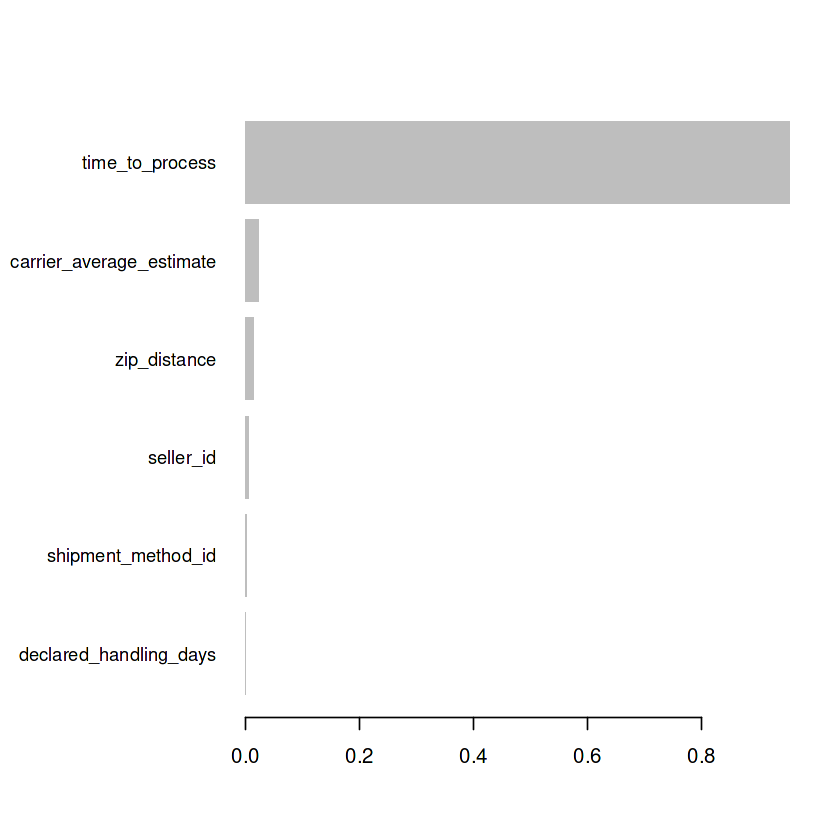

In [18]:
xgb.plot.importance(importance_matrix[1:6,])

# Decision Tree


In [19]:
# Create decision tree using regression
dt_model <- rpart(days_to_deliver ~ b2c_c2c+ declared_handling_days + shipment_method_id+shipping_fee+item_zip
            +buyer_zip+category_id+item_price+quantity+ weight+package_size+carrier_average_estimate+zip_distance+time_to_process, data = train)


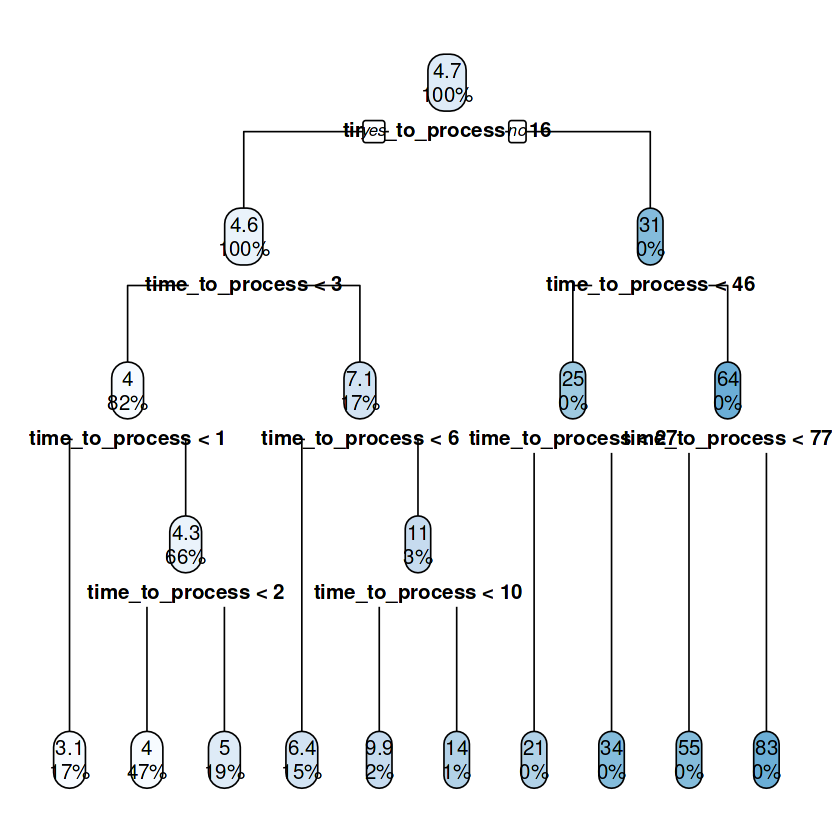

In [20]:
rpart.plot(dt_model)

In [21]:
dt_preds= predict(dt_model,test)

In [22]:
rmse_decision_tree = rmse(test$days_to_deliver,dt_preds)
print(rmse_decision_tree)

[1] 1.730644


In [23]:
evaluate_loss(round(dt_preds,0), test$days_to_deliver)


2 
0.507024

# Ridge Regression

In [24]:
#perform k-fold cross-validation to find optimal lambda value
cv_model <- cv.glmnet(train_x, train_y, alpha = 0)

#find optimal lambda value that minimizes test MSE
best_lambda <- cv_model$lambda.min
best_lambda

[1] 0.2513791

In [25]:
#ridge model
ridge_reg = glmnet(train_x, train_y, nlambda = 25, alpha = 0, family = 'gaussian', lambda = best_lambda)

In [26]:
# rr_model_preds <-predict(ridge_reg, test_x)
rr_model_preds <-predict(ridge_reg, test_x)

In [27]:
rmse_ridge = rmse(test$days_to_deliver,rr_model_preds)
print(rmse_ridge)

[1] 1.631548


In [28]:
evaluate_loss(round(rr_model_preds,0), test$days_to_deliver)

[1] 0.4982066